# STTMALST Gastrointestinal-Cancer-MSI-MSS-Prediction

**Project created and conducted by: Christopher Bernold and Ellen Þórðardóttir**

_Fall 2020_


Reference list and inspriation links:

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#top_of_page



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import datetime
import itertools
import pathlib
import random
from tensorflow.python.client import device_lib
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score


Setting global variables for entire project

In [2]:
#Variables:
batch_size = 10000
epochs = 100
img_height, img_width = 28,28

Specifying tensorflow to use a GPU but only allocate memory from GPU when needed. 

_Currently broken as tensorflow does not always detect NVIDIA RTX GPU's, searching for solution._

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print(device_lib.list_local_devices())

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10270822734857207189
]


Specifying dataset folder locations. Data is already split up into train test and validation set,
 meaning that we do not need to create a 80/20 split for the training and validation set.

In [4]:
DATA_PATH = './tcga_coad_msi_mss'
data_dir = pathlib.Path(DATA_PATH)
training_set_dir = os.path.join(DATA_PATH, 'train')
train_dir = pathlib.Path(training_set_dir)

test_set_dir = os.path.join(DATA_PATH, 'test')
test_dir = pathlib.Path(test_set_dir)

validation_set_dir = os.path.join(DATA_PATH,'val')
val_dir = pathlib.Path(validation_set_dir)

In [5]:
#Gets all images in all dataset folders
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print("Total amount of images is: ", image_count)

Total amount of images is:  192312


## Setting up the pipeline

In [6]:
list_train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)
list_train_ds = list_train_ds.shuffle(image_count, reshuffle_each_iteration=False)

list_val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'), shuffle=False)
list_val_ds = list_val_ds.shuffle(image_count, reshuffle_each_iteration=False)

list_test_ds = tf.data.Dataset.list_files(str(test_dir/'*/*'), shuffle=False)
list_test_ds = list_test_ds.shuffle(image_count, reshuffle_each_iteration=False)

Data is labelled based on folders and does not have a specified MSS/MSIMUT label on each image.

In [7]:
for f in list_train_ds.take(5):
  print(f.numpy())


b'tcga_coad_msi_mss\\train\\MSIMUT\\blk-NAMSWARKCYIR-TCGA-CM-4746-01Z-00-DX1.jpg'
b'tcga_coad_msi_mss\\train\\MSIMUT\\blk-GMVIRLEQYTPF-TCGA-AZ-4615-01Z-00-DX1.jpg'
b'tcga_coad_msi_mss\\train\\MSS\\blk-WHEIPRIGYQMA-TCGA-CM-6679-01Z-00-DX1.jpg'
b'tcga_coad_msi_mss\\train\\MSS\\blk-IHEPKGYVYNRH-TCGA-F5-6702-01Z-00-DX1.jpg'
b'tcga_coad_msi_mss\\train\\MSIMUT\\blk-HCNRLEHRSNQY-TCGA-CK-6746-01Z-00-DX1.jpg'


To fetch all of the class names we search in the training directory to get the class names and store them into a numpy array. 

In [8]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['MSIMUT' 'MSS']


Amount of images in the training folder

In [9]:
train_ds = list_train_ds
print(tf.data.experimental.cardinality(train_ds).numpy())


153849


**To have a pipeline which we have more control of, we need to map the image and label pairs (X, y) values. This is done and explain in the following functions**

When using categorical data it is wise to use one hot encoding. This is because when working with machine learning,<br>
 algorithms cannot use a labels string value directly, but instead requires all input and output values to instead be numeric values.<br>
 Here there are two typical ways of converting the categorical data into numeric data; integer encoding or One-Hot Encoding.<br>
 Integer encoding simply assigns each category an integer value e.g. MSIMUT would be assigned 1 and MSS would be assigned as 2. <br>
 One-Hot Encoding is one step above Integer encoding. Here categorical values are mapped to integer based values as with integer encoding,<br>
 each value is then represented as a binary vector containing zeros in every space other than the index of the integer which is marked as one.<br>
 Using one-hot encoding might be a little overkill in the project, but is still used as it is often very beneficial compared to integer encoding.<br>

 _references:_<br>

 https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
 
 https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
 

In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


In [12]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [14]:
#Labels are stored into an array, and as there only are two labels, the label can either be 0 or 1.
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (28, 28, 3)
Label:  0
Image shape:  (28, 28, 3)
Label:  0
Image shape:  (28, 28, 3)
Label:  1
Image shape:  (28, 28, 3)
Label:  1
Image shape:  (28, 28, 3)
Label:  0


In [15]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [16]:
train_ds = configure_for_performance(train_ds)
X_train, y_train = next(iter(train_ds))

print("training shapes: X=%s, y=%s", X_train.shape, y_train.shape)

training shapes: X=%s, y=%s (10000, 28, 28, 3) (10000,)


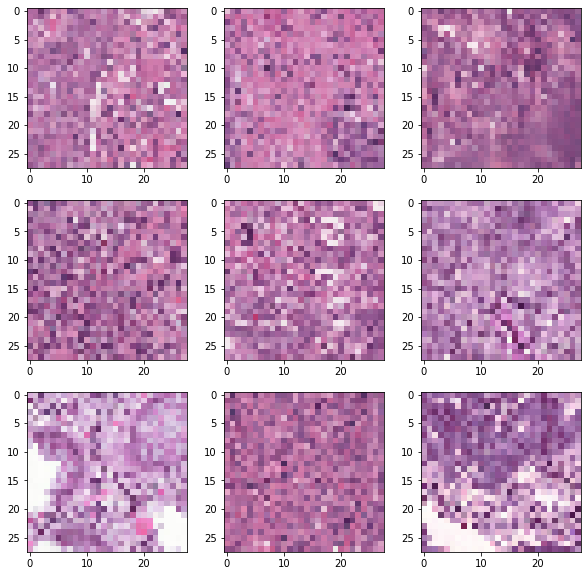

In [20]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i].numpy().astype("uint8"))
    plt.grid(False)
plt.show()

In [27]:
#X_train = X_train/255.0
print('Data Type: %s' % X_train.dtype)
print(tf.reduce_max(X_train))

Data Type: <dtype: 'float32'>
tf.Tensor(0.003921569, shape=(), dtype=float32)


Normalizing the data